In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt

import warnings
warnings.filterwarnings('ignore')

In [25]:
full_data = pd.read_csv('cohorts_data.csv', parse_dates=['reg_day','auth_day'])

In [26]:
full_data.head(3)

,uid,reg_day,auth_day
0,921244,2020-06-02,2020-06-02
1,921245,2020-06-02,2020-06-02
2,921245,2020-06-02,2020-06-04


In [27]:
print('Первая дата регистрации:', full_data.reg_day.min(), 'Последняя дата регистрации:', full_data.reg_day.max())
print('Первая дата авторизации:', full_data.auth_day.min(), 'Последняя дата авторизации:', full_data.auth_day.max())

Первая дата регистрации: 2020-06-02 00:00:00 Последняя дата регистрации: 2020-09-23 00:00:00
Первая дата авторизации: 2020-06-02 00:00:00 Последняя дата авторизации: 2020-09-23 00:00:00


In [28]:
# в качестве аргументов подаю датафрейм, первую и последнюю дату, которые задаст пользователь
def retention_rate(df, first_day, last_day):
# отфильтровываю данные в таблице по заданным датам 
    df = df[(df['reg_day'] >= first_day) & (df['auth_day'] <= last_day)]
# создаю столбец с разницей в днях между регистрацией и следующим заходом
    df['sub_days'] = df['auth_day'] - df['reg_day']
# группирую в когорты и считаю количество уникальных пользователей зашедших повторно, переименовываю
    cohorts = df.groupby(['reg_day','sub_days'], as_index=False).agg({'uid':'count'}) \
            .rename(columns={'uid':'counts_uid','reg_day':'cohort_name'})
# перевожу дни в числовой тип
    cohorts['sub_days'] = cohorts['sub_days'].dt.days
# создаю дополнительый датафрейм в который оставляю только тех кто зашел впервые
    cohorts_newfags = cohorts.query("sub_days == 0")
# удаляю ненужный столбец и переименовываю
    cohorts_newfags = cohorts_newfags.drop('sub_days', axis=1).rename(columns={'counts_uid':'newbie'})
# мерджу к изначальной таблице когорт
    cohorts = cohorts.merge(cohorts_newfags, on='cohort_name')   
# создаю новый столбец и считаю в него ретеншен
    cohorts['retention_rate'] = (cohorts['counts_uid'] * 100) / cohorts['newbie']
# округляю   
    cohorts['retention_rate'] = cohorts['retention_rate'].round(2)
# создаю сводную таблицу с ретеншеном
    retention = cohorts.pivot_table(index='cohort_name', columns='sub_days', values='retention_rate')
# возвращаю результат с таблицей

# делаю хитмэп для таблицы
    plt.rcParams['font.size'] = '12'
    plt.figure(figsize=(18,14))
    plt.title('Retention, %')
    ax = sns.heatmap(data=retention, annot=True, vmin=0, vmax=10 ,cmap='Greens', fmt=".1f")
    ax.set_yticklabels(retention.index)
    ax.set_xticklabels(retention.columns)
    fig=ax.get_figure()

    plt.show()
    
    return retention


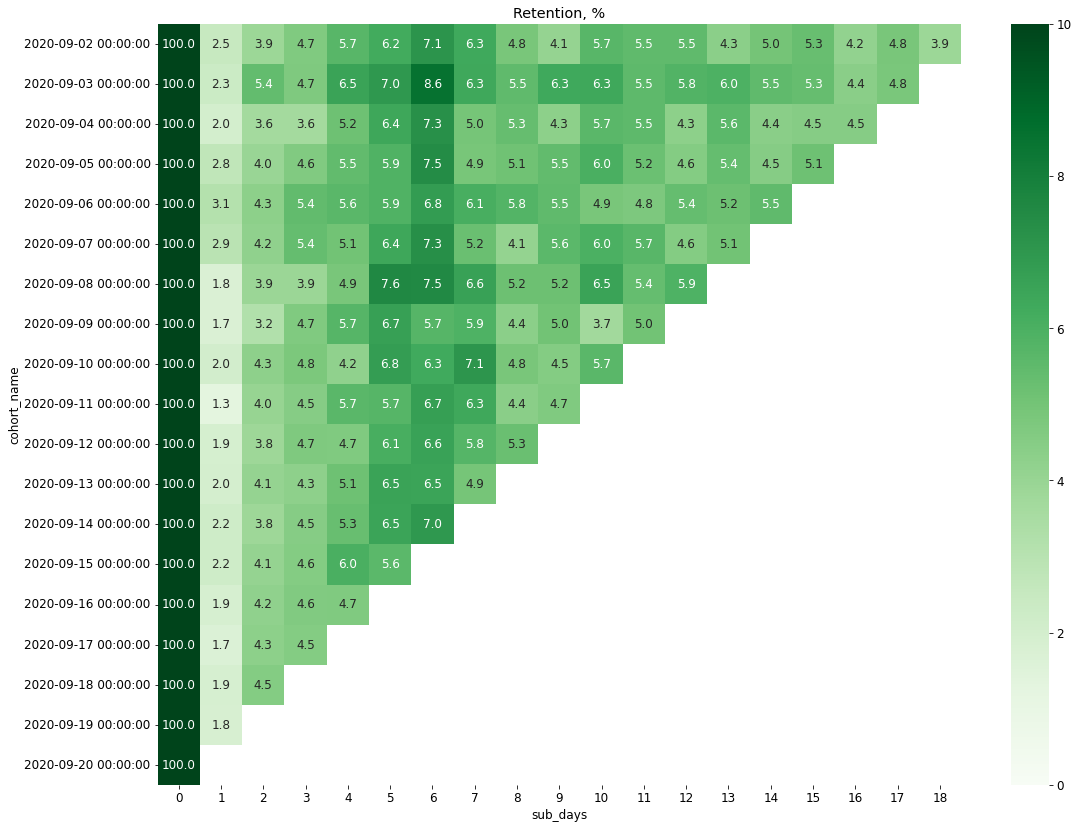

sub_days,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
cohort_name,,,,,,,,,,,,,,,,,,,
2020-09-02,100.0,2.52,3.90,4.66,5.67,6.23,7.12,6.30,4.85,4.09,5.67,5.48,5.48,4.35,4.97,5.29,4.16,4.85,3.9
2020-09-03,100.0,2.33,5.41,4.71,6.54,6.98,8.55,6.35,5.47,6.29,6.35,5.53,5.85,5.97,5.47,5.34,4.40,4.84,NaN
2020-09-04,100.0,2.01,3.64,3.64,5.15,6.40,7.28,4.96,5.34,4.33,5.65,5.52,4.33,5.59,4.39,4.52,4.52,NaN,NaN
2020-09-05,100.0,2.76,3.95,4.64,5.45,5.89,7.46,4.89,5.08,5.45,6.02,5.20,4.57,5.39,4.51,5.14,NaN,NaN,NaN
2020-09-06,100.0,3.13,4.32,5.44,5.63,5.88,6.82,6.07,5.82,5.50,4.88,4.75,5.38,5.19,5.50,NaN,NaN,NaN,NaN
2020-09-07,100.0,2.94,4.25,5.37,5.06,6.37,7.31,5.25,4.12,5.62,6.00,5.68,4.56,5.06,NaN,NaN,NaN,NaN,NaN
2020-09-08,100.0,1.75,3.93,3.93,4.86,7.61,7.54,6.61,5.17,5.17,6.55,5.36,5.92,NaN,NaN,NaN,NaN,NaN,NaN
2020-09-09,100.0,1.74,3.24,4.67,5.72,6.66,5.72,5.91,4.36,5.04,3.73,5.04,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-09-10,100.0,2.05,4.29,4.79,4.23,6.77,6.28,7.09,4.85,4.54,5.66,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
retention_rate(full_data, '2020-09-02', '2020-09-20')